In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Directory containing datasets
dataset_dir = 'datasets'

# List of dataset filenames and parameters
datasets = [
    {
        'filename': 'isotropic_blobs.csv',
        'title': 'Isotropic Gaussian Blobs',
        'n_components': 3,

        'reduce_dim': False
    },
    {
        'filename': 'anisotropic_blobs.csv',
        'title': 'Anisotropic Gaussian Blobs',
        'n_components': 3,

        'reduce_dim': False
    },
    {
        'filename': 'moons_circles.csv',
        'title': 'Moons and Circles',
        'n_components': 4,
        'reduce_dim': False
    },
    {
        'filename': 'overlapping_clusters.csv',
        'title': 'Overlapping Clusters',
        'n_components': 3,
        'reduce_dim': False
    },
    {
        'filename': 'high_dimensional_data.csv',
        'title': 'High-Dimensional Data with Noise',
        'n_components': 5,
        'reduce_dim': True  # Reduce dimensionality for visualization
    },
]

COLORS = [
    'blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan'
]


In [ ]:
from utils import load_dataset

# Plot the data in a grid with titles
import matplotlib.pyplot as plt
import numpy as np
import os

fig, axes = plt.subplots(1, len(datasets), figsize=(30, 10))

for ax, dataset in zip(axes, datasets):
    X, y = load_dataset(os.path.join(dataset_dir, dataset['filename']))
    ax.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap='Set1')
    ax.set_title(dataset['title'])
    ax.axis('equal')
    
plt.show()

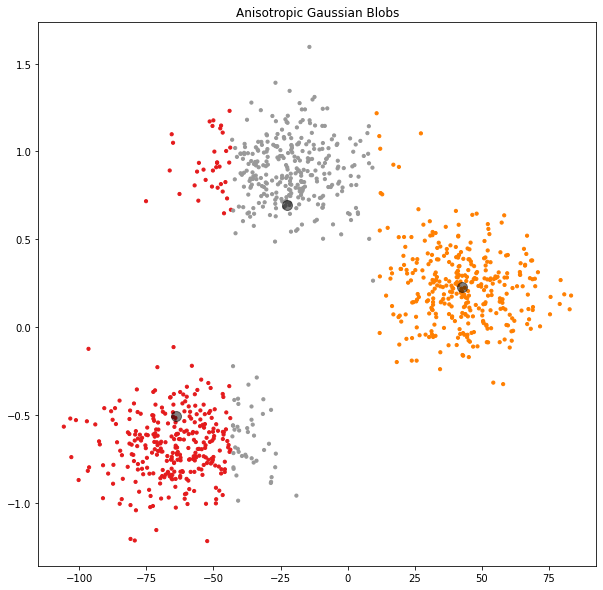

In [282]:
# import kmeans from sklearn
from sklearn.cluster import KMeans

# perform clustering on dataset[1] and plot the results
X, y = load_dataset(os.path.join(dataset_dir, datasets[1]['filename']))
kmeans = KMeans(n_clusters=datasets[1]['n_components'], init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10, cmap='Set1')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.title(datasets[1]['title'])
plt.show()


In [163]:
def calculate_wcss(X, clusters, centroids):
    wcss = 0
    for i, cluster in enumerate(clusters):
        for idx in cluster:
            wcss += np.sum((X[idx] - centroids[i]) ** 2)
    return wcss

# Plot the clusters and centroids
def plot_clusters(X, clusters, centroids, title=""):
    for idx, cluster in enumerate(clusters):
        points = X[cluster]
        plt.scatter(points[:, 0], points[:, 1], c=COLORS[idx % len(COLORS)], label=f'Cluster {idx+1}')
    centroids = np.array(centroids)
    WCSS = calculate_wcss(X, clusters, centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', label='Centroids', linewidths=4)
    # adjust the size of the plot
    plt.rcParams['figure.figsize'] = [10, 10]
    
    #Add the grid
    plt.grid()
    
    # Print the WCSS in scientific notation
    plt.title(f"{title}: WCSS: {WCSS}")


# Plot the clusters and centroids
def plot_clusters_with_track(X, clusters, centroids, centroid_track):

    
    # Plot the final centroids
    centroids = np.array(centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', linewidths=4)
    # adjust the size of the plot
    plt.rcParams['figure.figsize'] = [10, 10]
    
    #Add the grid
    plt.grid()
    # Plot the centroid tracks
    for idx in range(len(centroids)):
        centroid_path = centroid_track[:, idx, :]
        plt.plot(centroid_path[:, 0], centroid_path[:, 1], linestyle='--', marker='o', markersize=2, color=COLORS[idx % len(COLORS)], label=f'Centroid {idx+1} Path')
    plt.title("")
    plt.legend()
    plt.show()

In [164]:

def kmeans_custom(X, k, max_iters=100, initialisation='random', initial_values=None, random_state=42) -> tuple[np.array, np.array, np.array]:
    """
    @param X: np.array of shape (n_samples, n_features)
    @param k: int, number of clusters
    @param max_iters: int, maximum number of iterations
    @param random_state: int, seed for reproducibility
    @return clusters: list of lists, each list contains the indices of the data points in that cluster
    @return centroids: np.array of shape (k, n_features), final centroids
    @return centroid_track: np.array of shape (n_iters, k, n_features), track of centroid values over iterations
    """
    
    # set the seed for reproducibility
    np.random.seed(random_state)
    # Initialize centroids randomly
    n_samples, n_features = X.shape
    if initialisation == 'random':
        centroids = X[np.random.choice(n_samples, k, replace=False)]
    else:
        centroids = initial_values
    centroid_track = [centroids]  # Track centroid values over iterations for visualisation

    # Number of epochs
    for iter in range(max_iters):

        # Assign samples to closest centroids (create clusters)
        clusters = [[] for _ in range(k)] # clusters is a list of k empty lists. We will put our clustered data points in these lists
        
        for idx, point in enumerate(X):
            # For every point in the dataset, calculate the distance between the point and each centroid
            distances = [0 for _ in range(k)] # This will end up being a list of k distances for each point
            
            for i, centroid in enumerate(centroids):
                distance = 0
                for j in range(n_features):
                    distance += (point[j] - centroid[j])**2
                distances[i] += np.sqrt(distance)

            centroid_idx = np.argmin(distances) # Choose index of the the centroid with the smallest distance for that point
            clusters[centroid_idx].append(idx) # Add the point to the cluster with the smallest distance
        
        # Now we have assigned all points to clusters. We will now update the centroids
        new_centroids = []

        for cluster in clusters:
            if cluster:
                # The cluster is not empty, we will update the centroid to the mean of the points in the cluster
                new_centroids.append(X[cluster].mean(axis=0))
            else:
                # The cluster is empty, we will reinitialize it to a random point
                new_centroids.append(X[np.random.randint(0, n_samples)])
        new_centroids = np.array(new_centroids)
        centroid_track.append(new_centroids)
        
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids


    return clusters, centroids, np.array(centroid_track)

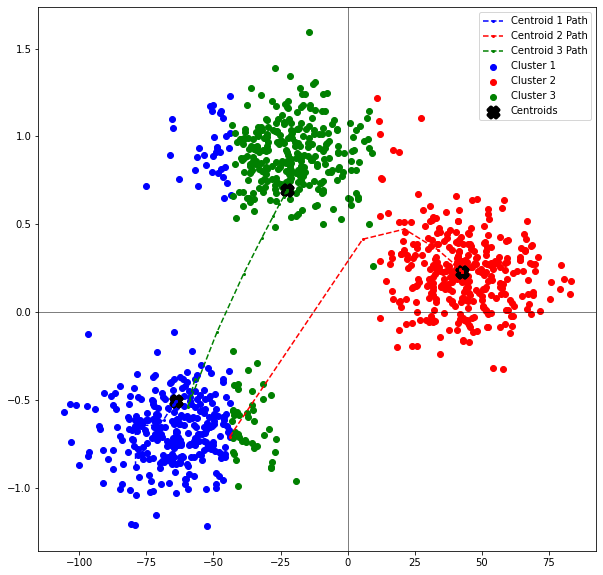

In [165]:
import matplotlib.pyplot as plt

# Use the first dataset
dataset = datasets[1]
X, labels = load_dataset(f'{dataset_dir}/{dataset["filename"]}')

clusters, centroids, track = kmeans_custom(X, 3, random_state=np.random.randint(0, 1000))

plt.figure(figsize=(10, 10))

plot_clusters(X, clusters, centroids)
# plot the axes 
plt.axhline(0, c='black', lw=0.5)
plt.axvline(0, c='black', lw=0.5)
plot_clusters_with_track(X, clusters, centroids, track)

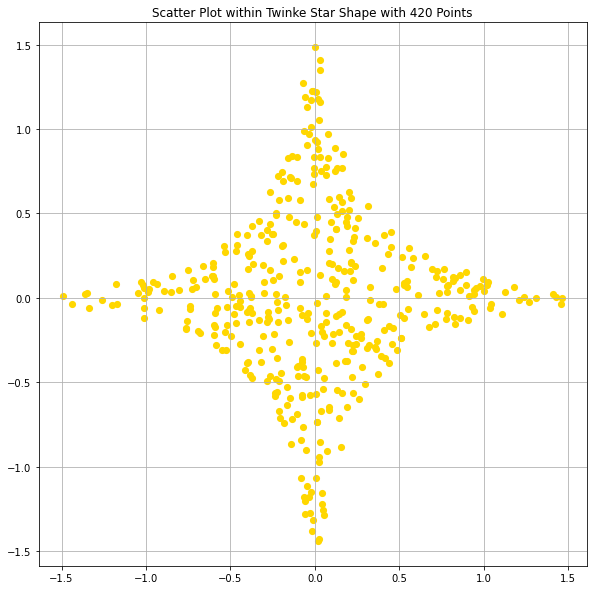

In [198]:
import numpy as np
import matplotlib.pyplot as plt

# Function to check if a point (x, y) is inside the star shape
def is_inside_star(x, y):
    return (np.abs(x)**(2/6) + np.abs(y)**(2/6)) <= 1.5

# Number of points to scatter
N = 1800

# Generate random points within the bounding box [-1.5, 1.5] x [-1.5, 1.5]
x_random = np.random.uniform(-1.5, 1.5, N)
y_random = np.random.uniform(-1.5, 1.5, N)

# Filter the points that fall within the star shape
inside_mask = is_inside_star(x_random, y_random)
x_star = x_random[inside_mask]
y_star = y_random[inside_mask]

# Plot the scatter plot of points inside the star
fig, ax = plt.subplots()
ax.scatter(x_star, y_star, color='gold', s=10, linewidths=4)  # Scatter plot of valid points

#Make the plot bigger
fig.set_size_inches(10, 10)

# Set equal scaling and grid
ax.set_aspect('equal')
ax.grid(True)

# Set the limits and display the plot

plt.title(f"Scatter Plot within Twinke Star Shape with {len(x_star)} Points")
plt.show()


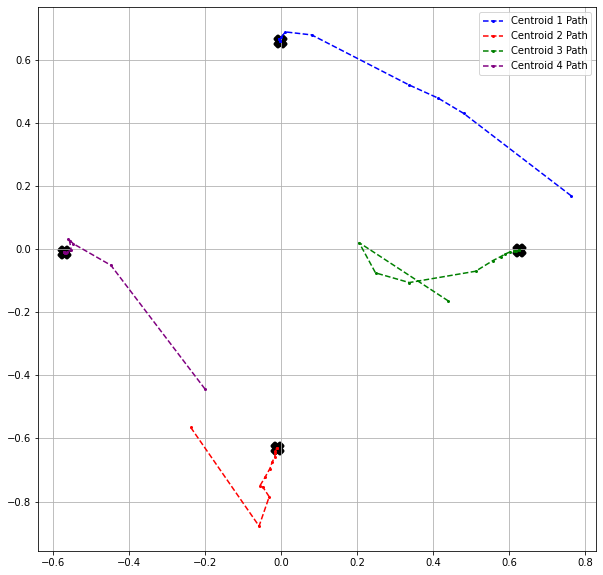

In [227]:
X = np.column_stack((x_star, y_star))

# Use the custom KMeans implementation
clusters, centroids, track = kmeans_custom(X, 4, random_state=65366)


# Plot the clusters and centroid track

plot_clusters_with_track(X, clusters, centroids, track)


In [201]:
unique_random_states = []

# find the random states that produce WCSS > 135
for i in range(100):
    clusters, centroids, track = kmeans_custom(X, 4, random_state=i)
    WCSS = calculate_wcss(X, clusters, centroids)
    if WCSS > 57:
        print(f"Random State: {i}, WCSS: {WCSS}")
        unique_random_states.append(i)

Random State: 0, WCSS: 85.46279506501112
Random State: 2, WCSS: 81.09060478499943
Random State: 39, WCSS: 85.45995564055805
Random State: 45, WCSS: 81.09060478499954
Random State: 49, WCSS: 81.09060478499951
Random State: 51, WCSS: 85.4522649550777
Random State: 57, WCSS: 81.09060478499948
Random State: 59, WCSS: 81.09060478499947
Random State: 65, WCSS: 85.45995564055805
Random State: 78, WCSS: 85.46343416407204
Random State: 85, WCSS: 83.8907856404116
Random State: 87, WCSS: 81.09060478499954


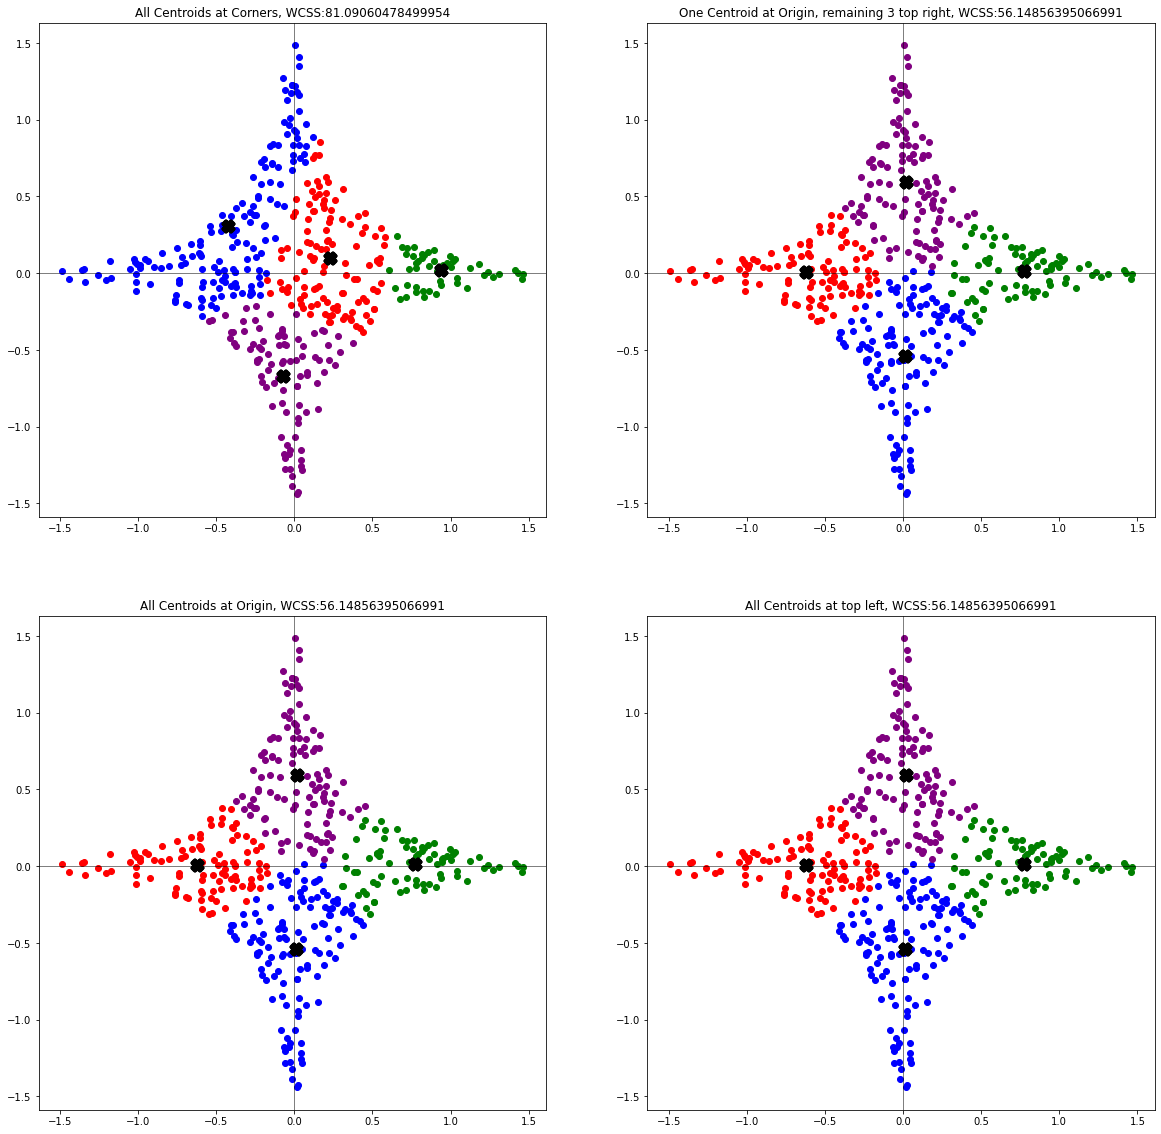

In [228]:
# Create 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

random_states = [99, 0, 2, 85]

custom_initialisations = [
    {
        "values": [
            [-3, 3], [3, -3], [3, 3], [-3, -3]
       ],
        "title": "All Centroids at Corners"
    },
    {
        "values": [
            [0, 0], [3, 3], [3, 3], [3, 3]
        ],
        "title": "One Centroid at Origin, remaining 3 top right"
    },
    {
        "values": [
            [0, 0], [0, 0], [0, 0], [0, 0]
        ],
        "title": "All Centroids at Origin"
    },
    {
        "values": [
            [-3, 3], [-3, 3], [-3, 3], [-3, 3]
        ],
        "title": "All Centroids at top left"
    }
]

# Plot the clusters for each random state
for ax, random_state in zip(axes.flatten(), custom_initialisations):
    clusters, centroids, track = kmeans_custom(X, 4, initialisation='cus', initial_values=random_state['values'])
    
    for idx, cluster in enumerate(clusters):
        points = X[cluster]
        ax.scatter(points[:, 0], points[:, 1], c=COLORS[idx % len(COLORS)], label=f'Cluster {idx+1}')
    centroids = np.array(centroids)
    WCSS = calculate_wcss(X, clusters, centroids)
    ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', label='Centroids', linewidths=4)
    
   # add the axes
    ax.axhline(0, c='black', lw=0.5)
    ax.axvline(0, c='black', lw=0.5)
    
    # # Print the WCSS in scientific notation
    ax.set_title(f"{random_state['title']}, WCSS:{WCSS}")
    
    # Plot the final centroids
    centroids = np.array(centroids)
    ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', linewidths=4)


    # # Plot the centroid tracks
    # for idx in range(len(centroids)):
    #     centroid_path = track[:, idx, :]
    #     ax.plot(centroid_path[:, 0], centroid_path[:, 1], linestyle='--', marker='o', markersize=2, color=COLORS[idx % len(COLORS)], label=f'Centroid {idx+1} Path')
   

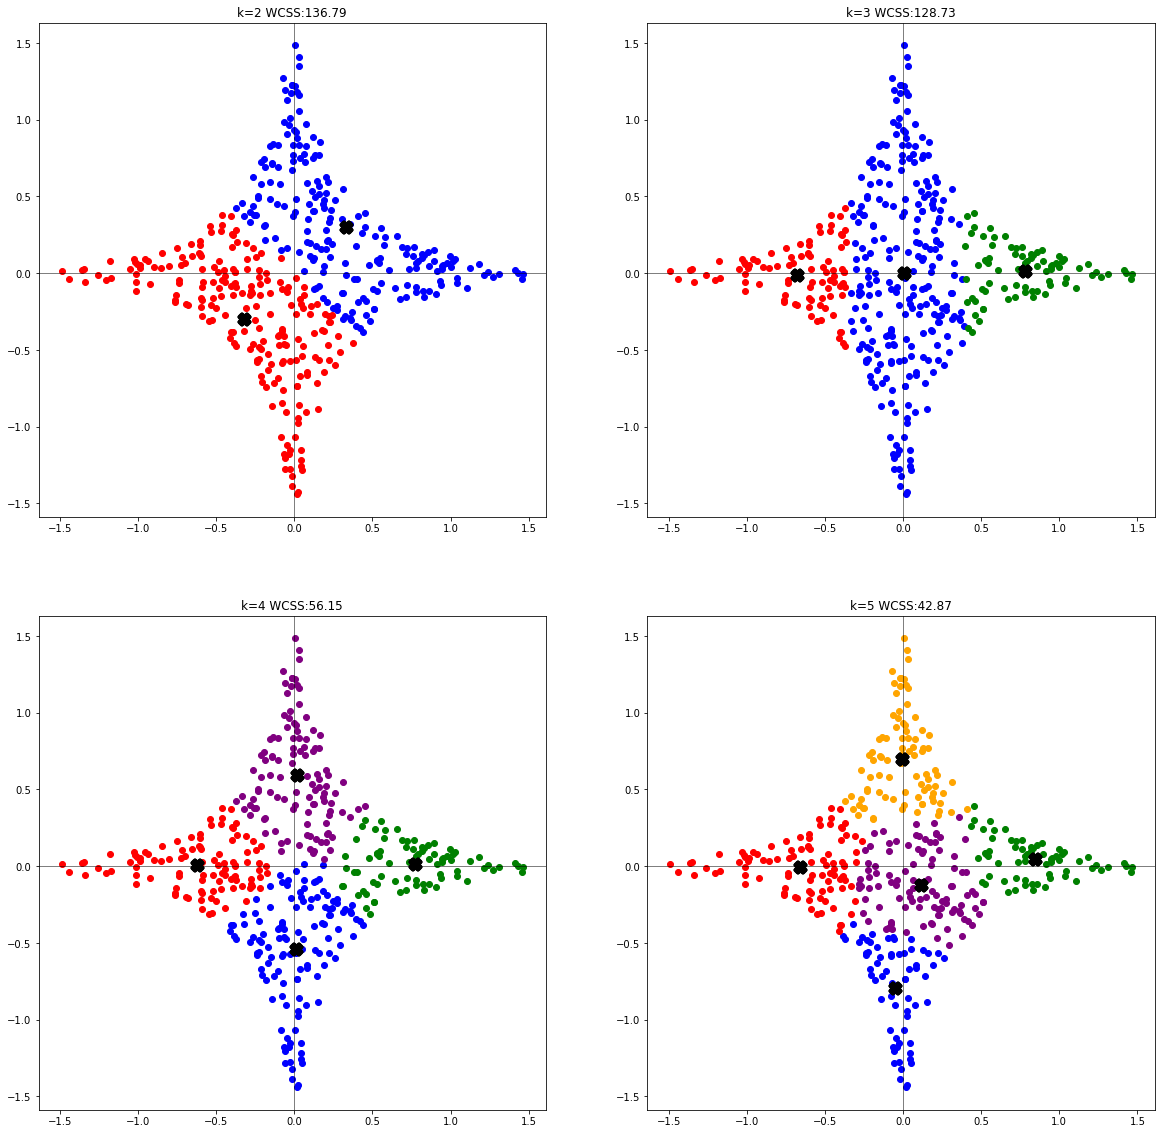

In [236]:
# Create 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

random_states = [99, 0, 2, 85]

k = 2
# Plot the clusters for each random state
for ax, random_state in zip(axes.flatten(), random_states):
    clusters, centroids, track = kmeans_custom(X, k, initialisation='cus', initial_values=[[0,0] for _ in range(k)])
    k += 1
    for idx, cluster in enumerate(clusters):
        points = X[cluster]
        ax.scatter(points[:, 0], points[:, 1], c=COLORS[idx % len(COLORS)], label=f'Cluster {idx+1}')
    centroids = np.array(centroids)
    WCSS = calculate_wcss(X, clusters, centroids)
    ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', label='Centroids', linewidths=4)
    
   # add the axes
    ax.axhline(0, c='black', lw=0.5)
    ax.axvline(0, c='black', lw=0.5)
    
    # # Print the WCSS in scientific notation
    ax.set_title(f"k={k-1} WCSS:{WCSS:.2f}")
    
    # Plot the final centroids
    centroids = np.array(centroids)
    ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', linewidths=4)


    # # Plot the centroid tracks
    # for idx in range(len(centroids)):
    #     centroid_path = track[:, idx, :]
    #     ax.plot(centroid_path[:, 0], centroid_path[:, 1], linestyle='--', marker='o', markersize=2, color=COLORS[idx % len(COLORS)], label=f'Centroid {idx+1} Path')
   

Text(0.5, 1.0, 'Elbow Graph for KMeans')

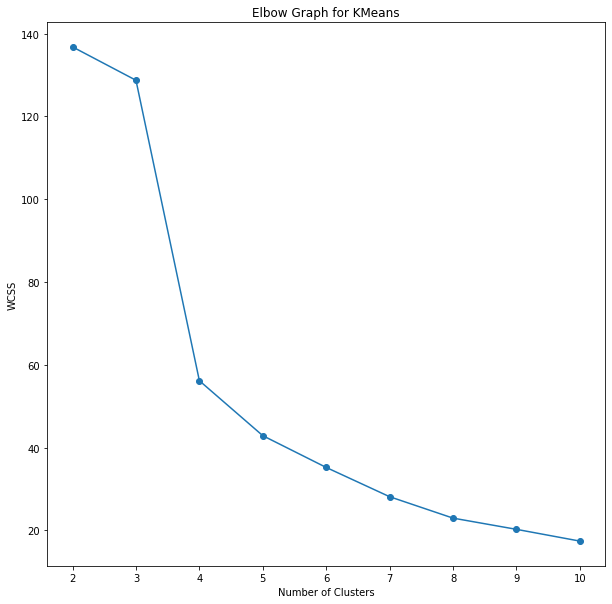

In [239]:
# Elbow graph for k vs WCSS
WCSS_values = []
k_values = range(2, 11)
for k in k_values:
    clusters, centroids, track = kmeans_custom(X, k,  initialisation='cus', initial_values=[[0,0] for _ in range(k)])
    WCSS = calculate_wcss(X, clusters, centroids)
    WCSS_values.append(WCSS)
    
plt.plot(k_values, WCSS_values, marker='o')
# label the axes
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Graph for KMeans")

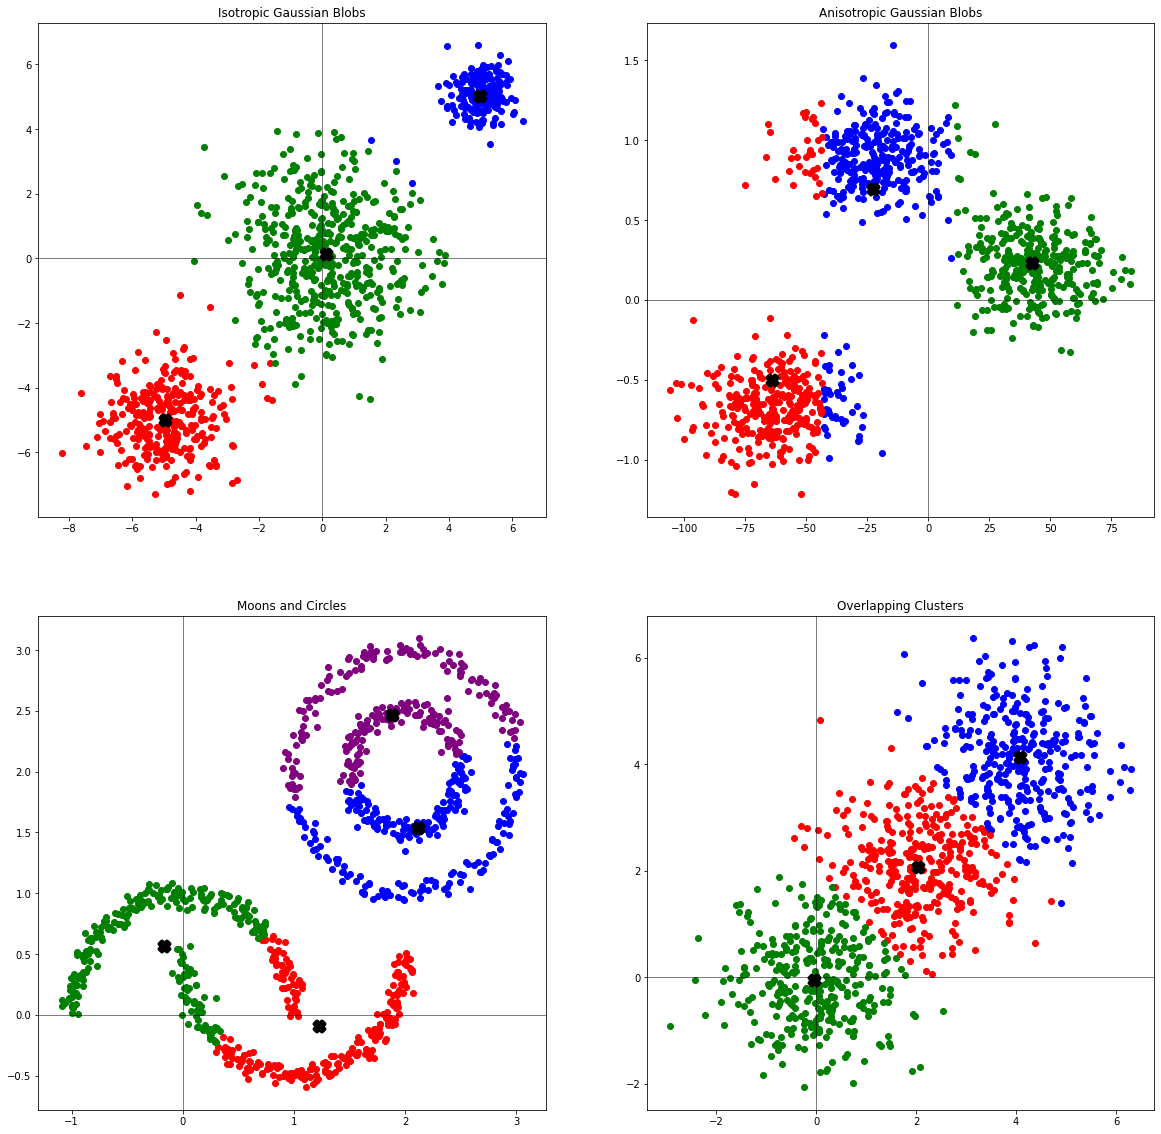

In [277]:
# next we want to visualise and evaluate the performance of the KMeans algorithm on the datasets

# Create 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Plot the clusters for each dataset

for ax, dataset in zip(axes.flatten(), datasets):
    
    X, labels = load_dataset(f'{dataset_dir}/{dataset["filename"]}')
    clusters, centroids, track = kmeans_custom(X, dataset['n_components'], random_state=np.random.randint(0, 1000))
    
    for idx, cluster in enumerate(clusters):
        points = X[cluster]
        ax.scatter(points[:, 0], points[:, 1], c=COLORS[idx % len(COLORS)], label=f'Cluster {idx+1}')

    centroids = np.array(centroids)
    WCSS = calculate_wcss(X, clusters, centroids)
    
    ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', label='Centroids', linewidths=4)
    # add the axes
    ax.axhline(0, c='black', lw=0.5)
    ax.axvline(0, c='black', lw=0.5)
    
    ax.set_title(f"{dataset['title']}")

    
    

In [274]:
from utils import visualize_clustering_results, evaluate_clustering
for dataset in datasets:
    X, labels = load_dataset(f'{dataset_dir}/{dataset["filename"]}')
    num_clusters = dataset['n_components']
    clusters, centroids, track = kmeans_custom(X, num_clusters)

    # Get the length of the dataset
    n_samples = X.shape[0]
    
    # Establish the predicted labels array
    predicted_labels = np.zeros(n_samples)
    
    for cluster_idx, cluster in enumerate(clusters):
        predicted_labels[cluster] = cluster_idx
    
    # visualize_clustering_results(X, predicted_labels, labels, f"KMeans on {dataset['title']}")
    evaluate_clustering(
        X, predicted_labels, labels, num_clusters, title=f"KMeans on {dataset['title']}"
    )
    

KMeans on Isotropic Gaussian Blobs
Adjusted Mutual Information: 0.9576
V-measure: 0.9576
Silhouette Score: 0.6774
KMeans on Anisotropic Gaussian Blobs
Adjusted Mutual Information: 0.7253
V-measure: 0.7258
Silhouette Score: 0.6361
KMeans on Moons and Circles
Adjusted Mutual Information: 0.5492
V-measure: 0.5506
Silhouette Score: 0.4056
KMeans on Overlapping Clusters
Adjusted Mutual Information: 0.7231
V-measure: 0.7236
Silhouette Score: 0.4782
KMeans on High-Dimensional Data with Noise
Adjusted Mutual Information: 0.9863
V-measure: 0.9864
Silhouette Score: 0.0549
